## Spectrogram Visualizer
The following notebook enables one to visualize the spectrogram he/she will get during trainig. This code aims to mimic the "getitem" functionalities, and show the spectrogram the model gets

In [1]:
import sys
from pathlib import Path
import yaml
from omegaconf import OmegaConf
import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint
import torch
import librosa.display


sys.path.append('..')

In [2]:
from soundbay.data import ClassifierDataset

/home/ubuntu/soundbay/.pywhale/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
## utils

class DotDictWrapper:
    """
    d['key']==d.key
    """
    def __init__(self, d):
        self._dict = d

    def __getattr__(self, name):
        if name in self._dict:
            return self._dict[name]
        else:
            raise AttributeError(f"'{type(self).__name__}' object has no attribute '{name}'")

    def __getitem__(self, key):
        return self._dict[key]

### Your params here

In [4]:
# edit filename
METADATA_PATH = '/home/ubuntu/soundbay/figs/shaye_annotations_added_nan_removed.csv'
METADATA_PATH = '/home/ubuntu/soundbay/datasets/shaye_dfs/train.csv'
df = pd.read_csv(METADATA_PATH)

# df['filename'] = df['filename'].apply(lambda x:x[:-4])

# df.to_csv('/home/ubuntu/soundbay/figs/shaye_annotations_added_nan_removed_fixed.csv', index=False)

In [5]:
# df.head()

In [6]:
# DATA_PATH = '/home/ubuntu/soundbay/datasets/shaye_data/'
# METADATA_PATH = '/home/ubuntu/soundbay/figs/shaye_annotations_added_nan_removed_fixed.csv'
DATA_PATH = '/home/ubuntu/soundbay/datasets/shaye_data_extended/'
METADATA_PATH = '/home/ubuntu/soundbay/datasets/shaye_dfs/train.csv'

# load augmentation and preprocessors - you can choose what yaml file to load by changing the path below
with open('../soundbay/conf/preprocessors/_mel_preprocessors.yaml', 'r') as file:
    preprocessors = yaml.safe_load(file)
with open('../soundbay/conf/augmentations/_augmentations.yaml', 'r') as file:
    augmentations = yaml.safe_load(file)
with open('../soundbay/conf/data/defaults.yaml', 'r') as file:
    data = yaml.safe_load(file)
    
data = data['data']
preprocessors=preprocessors['_preprocessors']
augmentations = augmentations['_augmentations']

In [7]:
pprint(preprocessors)

{'amplitude_2_db': {'_target_': 'torchaudio.transforms.AmplitudeToDB',
                    'top_db': 180},
 'mel_spectrogram': {'_target_': 'torchaudio.transforms.MelSpectrogram',
                     'f_max': '${data.max_freq}',
                     'f_min': '${data.min_freq}',
                     'hop_length': '${data.hop_length}',
                     'n_fft': '${data.n_fft}',
                     'n_mels': 64,
                     'pad_mode': 'constant',
                     'sample_rate': '${data.sample_rate}',
                     'win_length': '${data.n_fft}'}}


In [8]:
pprint(data)

{'batch_size': 128,
 'data_sample_rate': 16000,
 'hop_length': 256,
 'label_names': ['Noise', 'Call'],
 'label_type': 'single_label',
 'max_freq': 1000,
 'min_freq': 100,
 'n_fft': 1024,
 'num_workers': 4,
 'proba_threshold': 0.5,
 'sample_rate': 2000,
 'train_dataset': {'_target_': 'soundbay.data.ClassifierDataset',
                   'augmentations': '${_augmentations}',
                   'augmentations_p': 0.8,
                   'data_path': './datasets/shaye_data_extended',
                   'data_sample_rate': '${data.data_sample_rate}',
                   'margin_ratio': 0.5,
                   'metadata_path': './datasets/shaye_dfs/train.csv',
                   'mode': 'train',
                   'path_hierarchy': 0,
                   'preprocessors': '${_preprocessors}',
                   'sample_rate': '${data.sample_rate}',
                   'seq_length': 1,
                   'slice_flag': False},
 'val_dataset': {'_target_': 'soundbay.data.ClassifierDataset',
       

In [49]:
## you can tune the parameters from here, or you can change them in the yaml files and then load again
print(f"before: {data['data_sample_rate']}")
data['data_sample_rate'] = 16000
print(f"after: {data['data_sample_rate']}")
print(f"before: {data['sample_rate']}")
data['sample_rate'] = 2000 
print(f"after: {data['sample_rate']}")
# data['sample_rate'] = 44000
data['train_dataset']['augmentations_p'] = 0
data['max_freq'] = 1000
data['min_freq'] = 100
data['n_fft'] =  1024
data['hop_length'] = 32
# data['sample_rate'] = 44000
data['train_dataset']['seq_length'] = 1
# data['train_dataset']['margin_ratio'] = 0


# data['sample_rate'] = 16000

before: 16000
after: 16000
before: 2000
after: 2000


In [50]:
# preprocessors.pop('peak_norm')
# preprocessors.pop('min_freq_filtering')
# preprocessors.pop('amplitude_2_db')

In [51]:
# preprocessors.pop('peak_norm')

In [52]:
preprocessors

{'mel_spectrogram': {'_target_': 'torchaudio.transforms.MelSpectrogram',
  'sample_rate': '${data.sample_rate}',
  'n_fft': '${data.n_fft}',
  'hop_length': '${data.hop_length}',
  'win_length': '${data.n_fft}',
  'pad_mode': 'constant',
  'n_mels': 64,
  'f_min': '${data.min_freq}',
  'f_max': '${data.max_freq}'},
 'amplitude_2_db': {'_target_': 'torchaudio.transforms.AmplitudeToDB',
  'top_db': 180}}

In [53]:
data

{'label_names': ['Noise', 'Call'],
 'batch_size': 128,
 'num_workers': 4,
 'sample_rate': 2000,
 'data_sample_rate': 16000,
 'min_freq': 100,
 'max_freq': 1000,
 'n_fft': 1024,
 'hop_length': 32,
 'label_type': 'single_label',
 'proba_threshold': 0.5,
 'train_dataset': {'_target_': 'soundbay.data.ClassifierDataset',
  'data_path': './datasets/shaye_data_extended',
  'path_hierarchy': 0,
  'mode': 'train',
  'metadata_path': './datasets/shaye_dfs/train.csv',
  'augmentations_p': 0,
  'augmentations': '${_augmentations}',
  'preprocessors': '${_preprocessors}',
  'seq_length': 1,
  'margin_ratio': 0.5,
  'data_sample_rate': '${data.data_sample_rate}',
  'sample_rate': '${data.sample_rate}',
  'slice_flag': False},
 'val_dataset': {'_target_': 'soundbay.data.ClassifierDataset',
  'data_path': './datasets/shaye_data_extended',
  'path_hierarchy': 0,
  'mode': 'val',
  'metadata_path': './datasets/shaye_dfs/val.csv',
  'augmentations_p': 0,
  'augmentations': None,
  'preprocessors': '${_pr

In [54]:
aggr_conf = OmegaConf.create({'data':data, 'preprocessors':preprocessors, 'augmentations':augmentations})

In [55]:
cfg = DotDictWrapper({
    'data_path': DATA_PATH,
    'metadata_path': METADATA_PATH,
    'augmentations': aggr_conf.augmentations,
    'augmentations_p': aggr_conf.data.train_dataset.augmentations_p,
    'preprocessors': aggr_conf.preprocessors,
    'seq_length': aggr_conf.data.train_dataset.seq_length,
    'data_sample_rate': aggr_conf.data.data_sample_rate,
    'sample_rate': aggr_conf.data.sample_rate,
    'mode': "train",
    'slice_flag': False,
    'margin_ratio': 0,
    'split_metadata_by_label': False,
})

# cfg_val = ... 

# initiate the dataset

dataset_train = ClassifierDataset(cfg.data_path, cfg.metadata_path, cfg.augmentations, cfg.augmentations_p, cfg.preprocessors, None,
                 cfg.seq_length, cfg.data_sample_rate, cfg.sample_rate, cfg.mode,
                 cfg.slice_flag, cfg.margin_ratio, cfg.split_metadata_by_label)

In [56]:
dataset_train.metadata.shape

(1884, 9)

In [58]:
dataset_train.metadata.head()

,Unnamed: 0,filename,call_length,begin_time,end_time,label,Species,annotations_filename,s3_path
0,1,7205.230206192729,27.49528,216.20642,243.7017,0,AC,FlumeL_mixed_23.02.06_HALFHOUR_Sounds.selectio...,s3://deepvoice-user-uploads/shayetudor@gmail.c...
1,2,7205.230206192729,2.10696,244.05114,246.1581,0,AC,FlumeL_mixed_23.02.06_HALFHOUR_Sounds.selectio...,s3://deepvoice-user-uploads/shayetudor@gmail.c...
2,3,7205.230206232730,137.05251,137.94459,274.9971,0,AC,FlumeL_mixed_23.02.06_HALFHOUR_Sounds.selectio...,s3://deepvoice-user-uploads/shayetudor@gmail.c...
3,4,7205.230207002730,31.11138,44.05642,75.1678,0,AC,FlumeL_mixed_23.02.06_HALFHOUR_Sounds.selectio...,s3://deepvoice-user-uploads/shayetudor@gmail.c...
4,5,7205.230207002730,21.64164,75.46586,97.1075,0,AC,FlumeL_mixed_23.02.06_HALFHOUR_Sounds.selectio...,s3://deepvoice-user-uploads/shayetudor@gmail.c...


___
---

### Functionalities from getitem

In [59]:
"""
__getitem__ method loads item according to idx from the metadata
path_to_file, begin_time, end_time, label, channel = self._grab_fields(idx)
audio = self._get_audio(path_to_file, begin_time, end_time, label, channel)
audio_raw = self.sampler(audio)
audio_augmented = self.augment(audio_raw)
audio_processed = self.preprocessor(audio_augmented)
"""

'\n__getitem__ method loads item according to idx from the metadata\npath_to_file, begin_time, end_time, label, channel = self._grab_fields(idx)\naudio = self._get_audio(path_to_file, begin_time, end_time, label, channel)\naudio_raw = self.sampler(audio)\naudio_augmented = self.augment(audio_raw)\naudio_processed = self.preprocessor(audio_augmented)\n'

In [60]:
# def show_spectrogram(audio_processed,begin_time, end_time,  title, label):
#     plt.figure()
#     librosa.display.specshow(audio_processed)
#     plt.title(f"{str(title)} label: {label}")
#     plt.show()

def format_time(samples: float, sr: int) -> str:
    seconds = samples / sr  # Use floating-point division
    minutes = int(seconds // 60)
    seconds_remain = int(seconds % 60)
    milliseconds = int((seconds - int(seconds)) * 1000)
    return f"{minutes:02}:{seconds_remain:02}.{milliseconds:03}"

def show_spectrogram(audio_processed, begin_time, end_time, title, label, sr=1000):
    # plt.figure(figsize=(10, 4))
    
    # Show the spectrogram with time axis
    librosa.display.specshow(audio_processed, x_axis=None)
    
    # Plot begin and end time as vertical lines
    # plt.axvline(x=begin_time, color='green', linestyle='--', label='Begin Time')
    # plt.axvline(x=end_time, color='red', linestyle='--', label='End Time')
    
    num_frames = audio_processed.shape[1]
        # Format begin_time and end_time
    begin_sec = begin_time
    end_sec = end_time
    
    begin_label = format_time(begin_sec, sr)
    end_label = format_time(end_sec, sr)

    # Apply custom tick labels
    plt.xticks([0, num_frames - 1], [begin_label, end_label])
    
    plt.title(f"{title} | Label: {label}")
    # plt.colorbar(format='%+2.0f dB')
    # plt.legend()
    # plt.tight_layout()
    plt.show()

In [61]:
indices_to_check = [24,1640,1612, 1500]

audio.shape: torch.Size([1, 16000])
audio_raw.shape: torch.Size([1, 2000])
audio_augmented.shape: torch.Size([1, 2000])
audio_processed.shape: torch.Size([1, 64, 63])


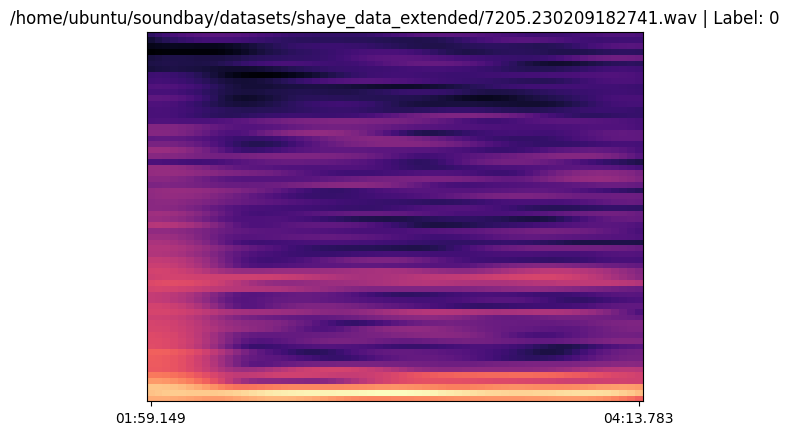

audio.shape: torch.Size([1, 16000])
audio_raw.shape: torch.Size([1, 2000])
audio_augmented.shape: torch.Size([1, 2000])
audio_processed.shape: torch.Size([1, 64, 63])


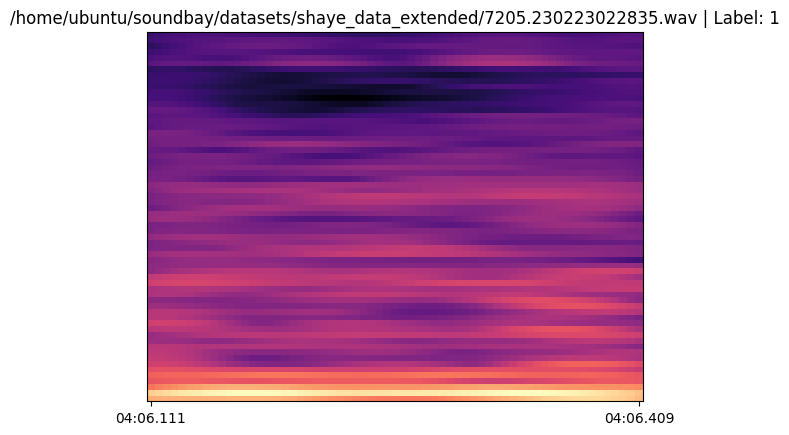

audio.shape: torch.Size([1, 16000])
audio_raw.shape: torch.Size([1, 2000])
audio_augmented.shape: torch.Size([1, 2000])
audio_processed.shape: torch.Size([1, 64, 63])


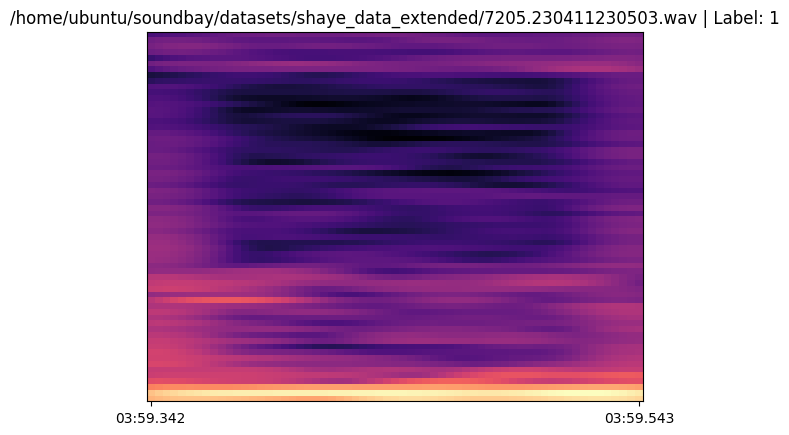

audio.shape: torch.Size([1, 16000])
audio_raw.shape: torch.Size([1, 2000])
audio_augmented.shape: torch.Size([1, 2000])
audio_processed.shape: torch.Size([1, 64, 63])


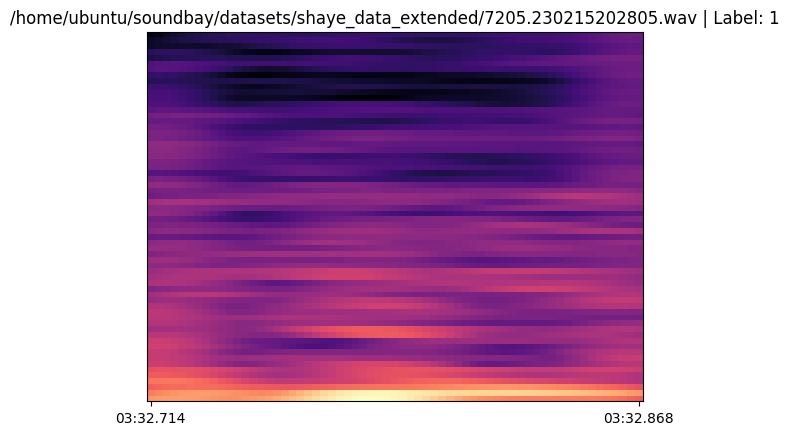

In [62]:
for idx in indices_to_check:
    path_to_file, begin_time, end_time, label, channel = dataset_train._grab_fields(idx)
    audio = dataset_train._get_audio(path_to_file, begin_time, end_time, label, channel)
    print(f"audio.shape: {audio.shape}")
    audio_raw = dataset_train.sampler(audio)
    print(f"audio_raw.shape: {audio_raw.shape}")
    audio_augmented = dataset_train.augment(audio_raw)
    print(f"audio_augmented.shape: {audio_augmented.shape}")
    audio_processed = dataset_train.preprocessor(audio_augmented)
    print(f"audio_processed.shape: {audio_processed.shape}")
    
    
    audio_processed = audio_processed.squeeze().cpu().numpy()
    show_spectrogram(audio_processed, begin_time, end_time, title=path_to_file, label=label,sr=cfg.data_sample_rate)